In [27]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from scipy.stats import norm

# This is just until temporary implementation
import os 
import sys
cwd = os.getcwd()
sys.path.insert(0,cwd + '/../timetransformers')


import Transformer 


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [28]:
device = torch.device("cpu")

In [55]:
import importlib

importlib.reload(Transformer)

output_dim = 2  # To begin with we can use a Gaussian with mean and variance
d_model = 32
num_heads = 1
num_layers = 2
d_ff = 128
max_seq_length = 200
dropout = 0.0

transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    device=device,
).to(device)

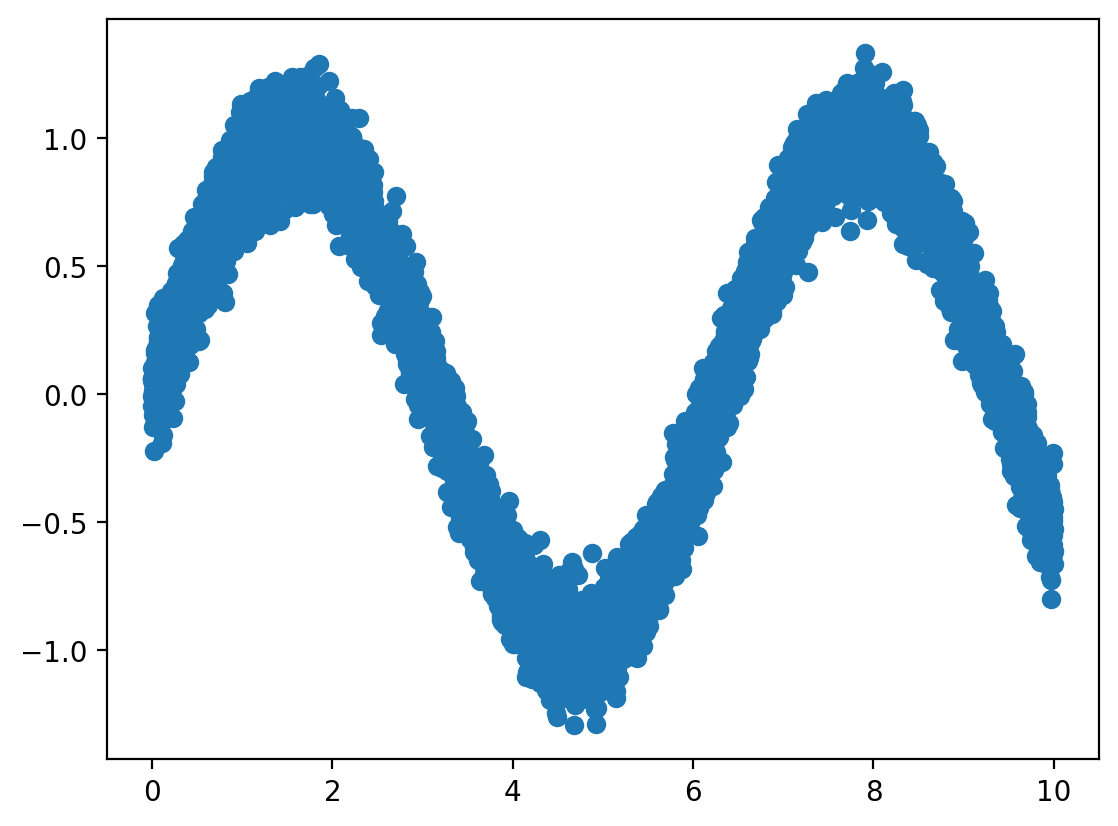

In [56]:
# Ok lets generate some fake time series data
n_data = 10_000
t = np.linspace(0, 10, n_data)
y1 = np.sin(t) + np.random.normal(0, 0.1, n_data)

# Lets plot it
plt.scatter(t, y1)
plt.show()

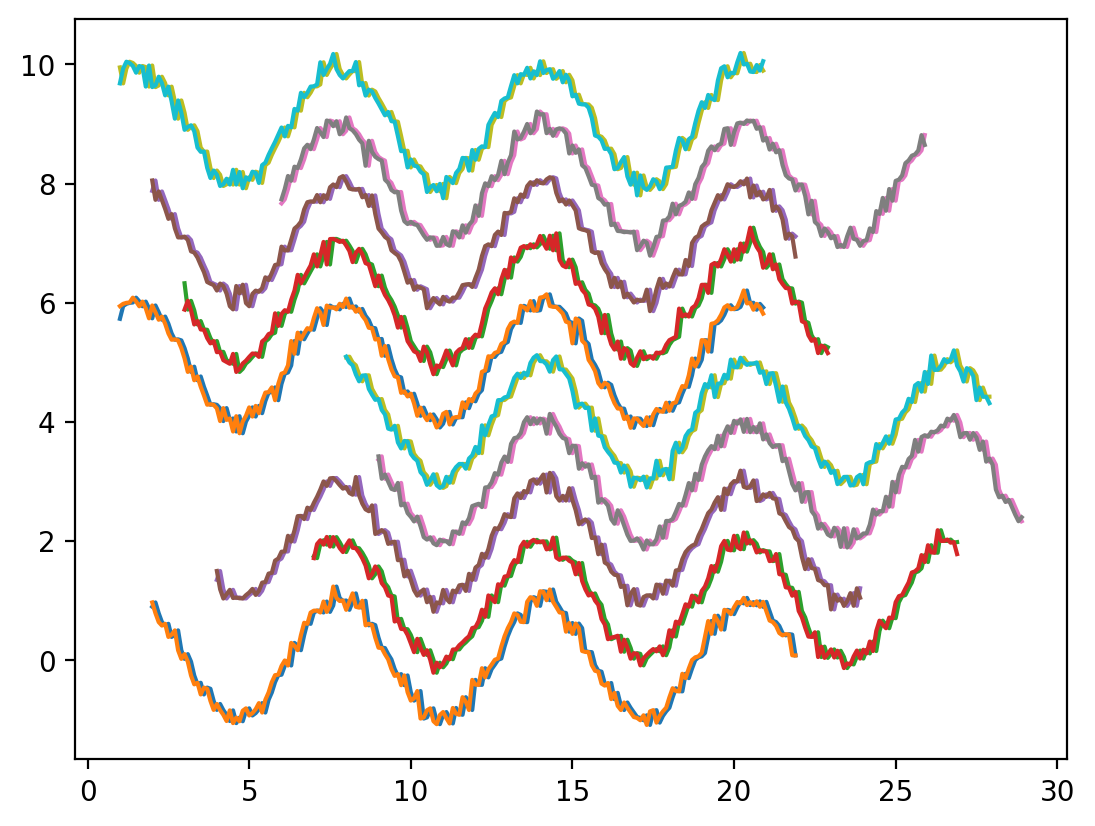

In [57]:
# We now need to package this up into random subsets of time series data
batch_size = 2048


def gen_sin_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,)).to(device)
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 20, max_seq_length + 1
            ).to(device)
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            torch.sin(batch_time).to(device)
            + torch.randn(max_seq_length + 1).to(device) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


def gen_linear_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,))
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 10, max_seq_length + 1
            )
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            batch_time + torch.randn(max_seq_length + 1) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


times, y_train, y_true = gen_sin_training_data(batch_size)
# times, y_train, y_true = gen_linear_training_data(batch_size)
for i in range(10):
    plt.plot(times[i].cpu(), y_train[i].cpu() + i)
    plt.plot(times[i].cpu(), y_true[i].cpu() + i)

plt.show()

In [58]:
print(y_train.shape, y_true.shape)

torch.Size([2048, 200, 1]) torch.Size([2048, 200])


In [59]:
y_train.shape

torch.Size([2048, 200, 1])

In [60]:
optimizer = optim.Adam(transformer.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=50, verbose=True, factor=0.5
)

transformer.train()

losses = []

for rnd in range(20):
    batch_size = 256
    with tqdm.trange(100) as progress:
        for epoch in progress:
            times, y_train, y_true = gen_sin_training_data(batch_size)
            optimizer.zero_grad()
            output = transformer(y_train)
            loss = transformer.Gaussian_loss(output, y_true)
            losses.append(loss.item())
            loss.backward()

            optimizer.step()

            progress.set_postfix(ordered_dict={"loss: ": loss.item()})
            scheduler.step(loss)

 95%|█████████▌| 95/100 [00:18<00:00,  5.34it/s, loss: =-.614] 

Epoch 00094: reducing learning rate of group 0 to 5.0000e-03.


 46%|████▌     | 46/100 [00:08<00:10,  5.17it/s, loss: =-1.92] 

Epoch 00145: reducing learning rate of group 0 to 2.5000e-03.


 14%|█▍        | 14/100 [00:02<00:16,  5.24it/s, loss: =-3.04]

Epoch 00813: reducing learning rate of group 0 to 1.2500e-03.


 23%|██▎       | 23/100 [00:04<00:14,  5.33it/s, loss: =-3.06]

Epoch 00922: reducing learning rate of group 0 to 6.2500e-04.


 15%|█▌        | 15/100 [00:02<00:16,  5.23it/s, loss: =-3.04]

Epoch 01014: reducing learning rate of group 0 to 3.1250e-04.


 65%|██████▌   | 65/100 [00:12<00:06,  5.08it/s, loss: =-3.05]


KeyboardInterrupt: 

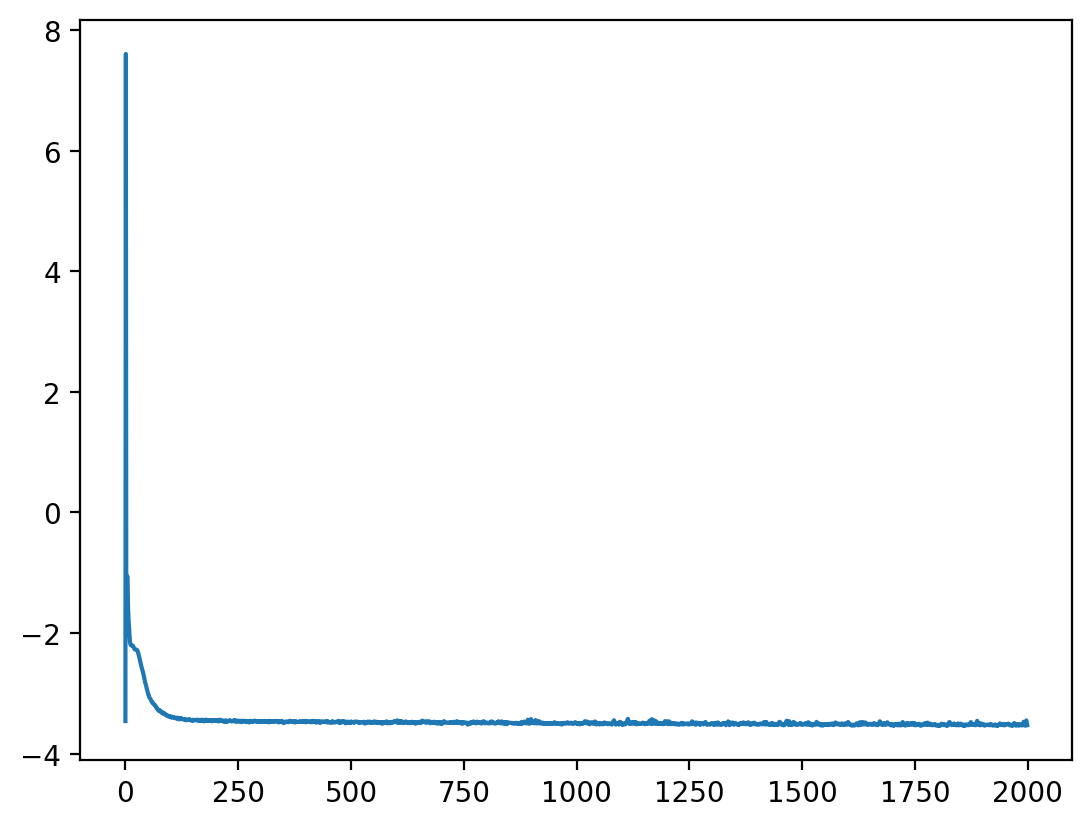

In [23]:
plt.plot(losses)

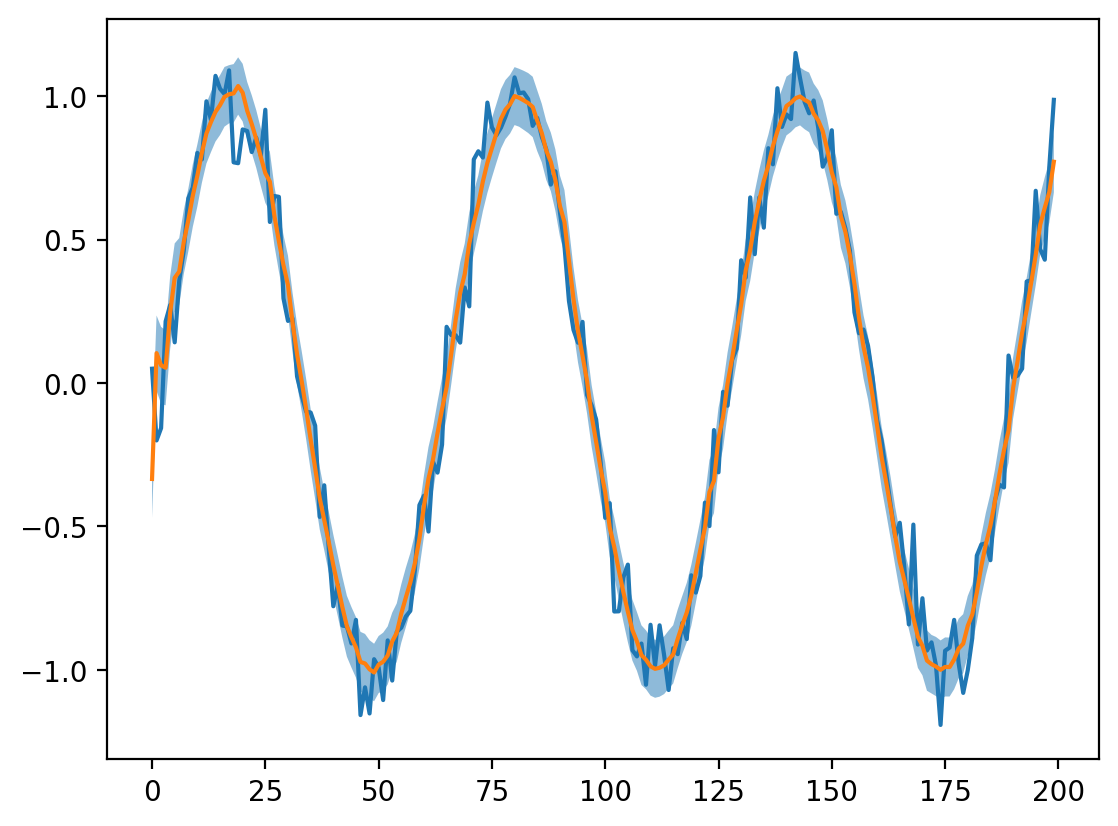

In [24]:
i = 0
output = transformer(y_train)
plt.plot(y_true[i, :].cpu())
mean = output[i, :, 0].detach().cpu()
std = torch.sqrt(torch.nn.functional.softplus(output[i, :, 1].detach().cpu()))
plt.plot(mean)
plt.fill_between(np.arange(mean.shape[0]), mean - std, mean + std, alpha=0.5)
plt.show()

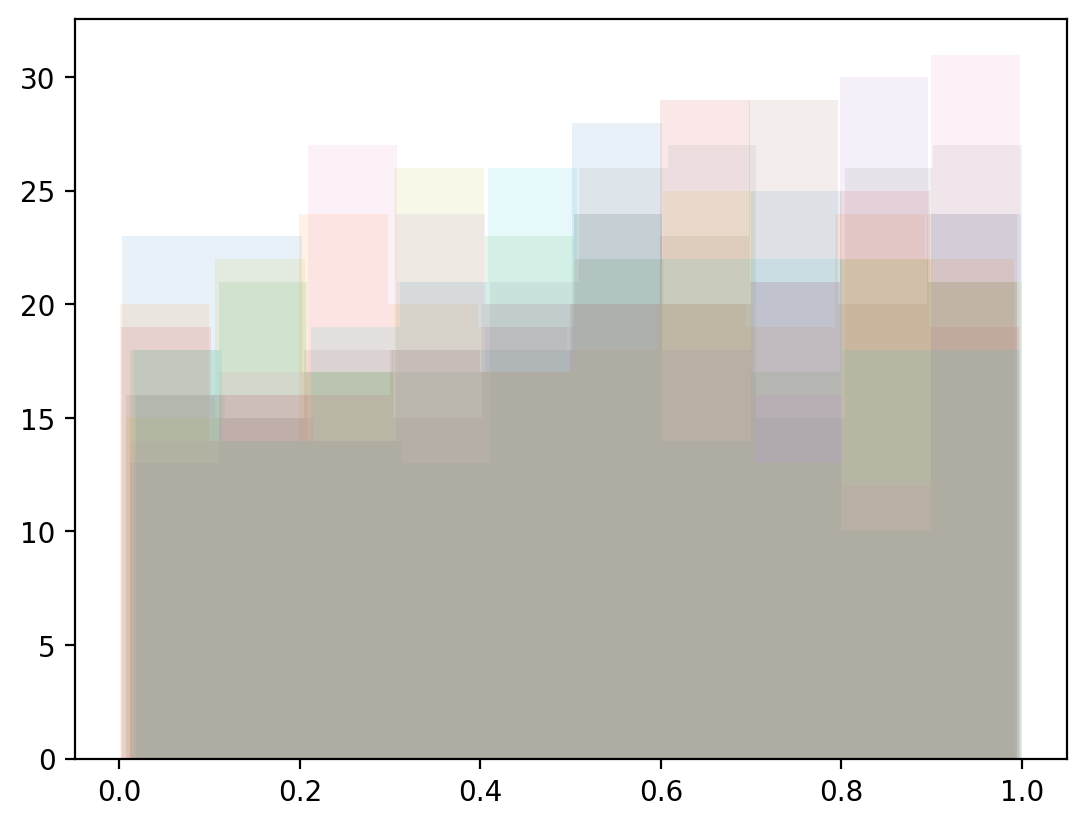

In [25]:
def PIT(transformer_pred, y_true):
    mean = transformer_pred[:, :, 0].cpu().detach().numpy()
    var = torch.nn.functional.softplus(transformer_pred[:, :, 1])
    std = np.sqrt(var.cpu().detach().numpy())

    U = norm.cdf(
        y_true.cpu().detach().numpy(),
        loc=mean,
        scale=std,
    )
    return U


u = PIT(output, y_true)

for i in range(10):
    plt.hist(u[i], alpha=0.1)

plt.show()

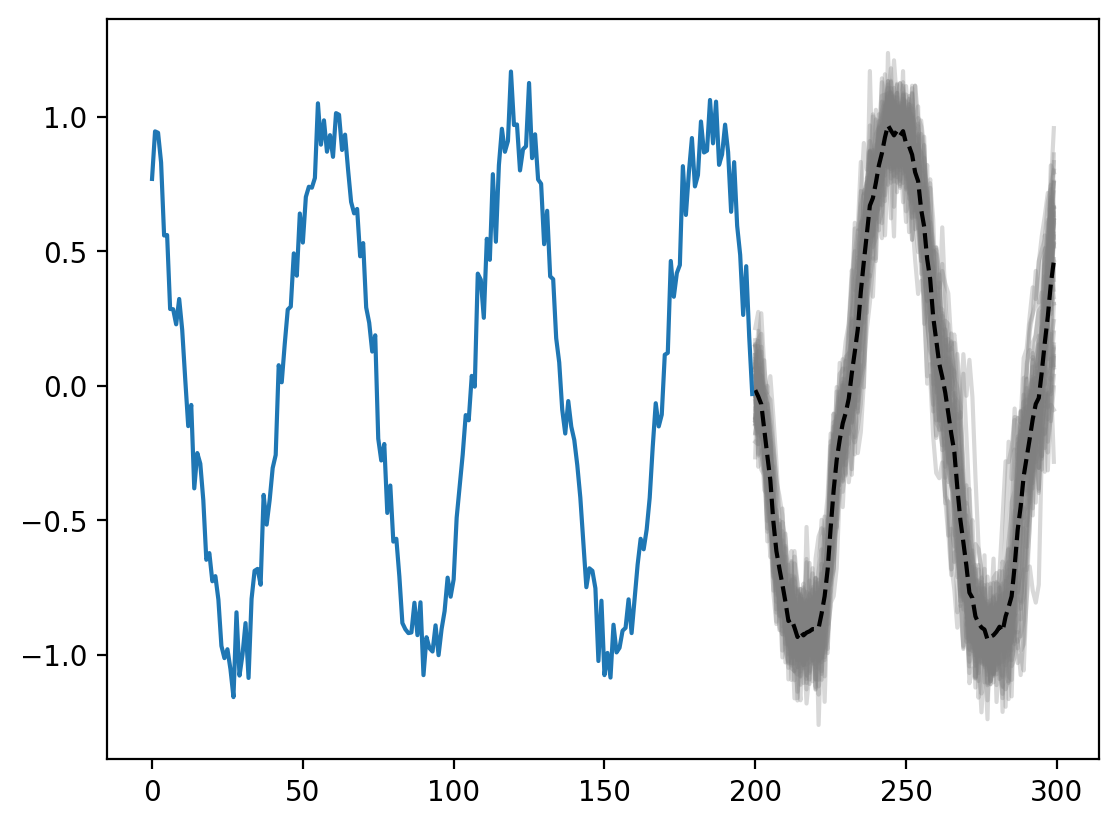

In [26]:
importlib.reload(Transformer)
Nlines = 50
rand_idx = torch.randint(0, y_train.shape[0], (1,))[0]

for i in range(Nlines):
    # Generate the next n_sequence elements
    n_sequence = 100
    generated_sequence = []

    transformer.eval()

    # Initial input for the model
    current_input = y_train[rand_idx].unsqueeze(0)

    sequence = transformer.generate(current_input, n_sequence)

    if i == 0:
        sequence_average = sequence
    else:
        sequence_average += sequence
    plt.plot(
        np.arange(y_train[rand_idx].shape[0], y_train[0].shape[0] + sequence.shape[1]),
        sequence[0, :].detach().cpu(),
        alpha=0.3,
        color="grey",
    )

plt.plot(
    np.arange(
        y_train[rand_idx].shape[0], y_train[rand_idx].shape[0] + sequence.shape[1]
    ),
    sequence_average[0, :].detach().cpu() / Nlines,
    color="k",
    ls="--",
)
plt.plot(np.arange(0, y_train[rand_idx].shape[0]), y_train[rand_idx].cpu())
plt.show()

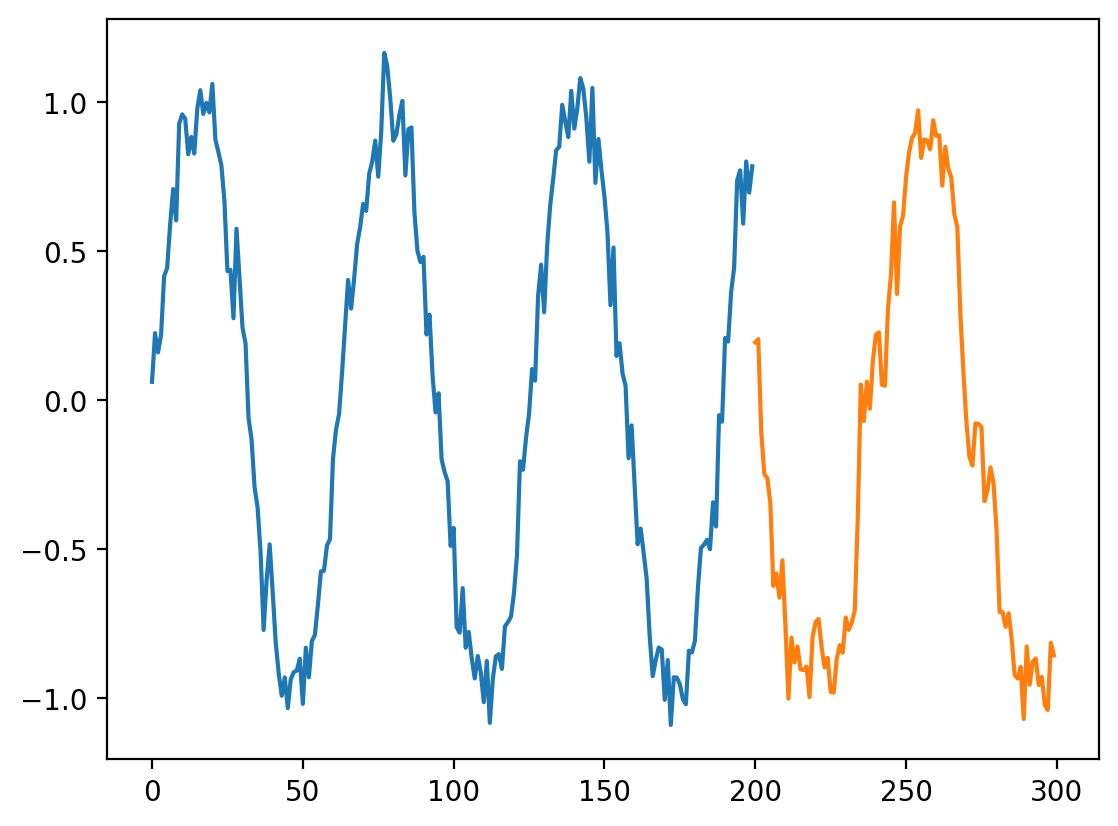

In [21]:
plt.plot(np.arange(0, y_train[0].shape[0]), y_train[0].cpu())
plt.plot(
    np.arange(y_train[0].shape[0], y_train[0].shape[0] + sequence.shape[1]),
    sequence[0, :].detach().cpu(),
)
plt.show()